In [1]:
from ucimlrepo import fetch_ucirepo 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import cdist
import time
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy import linalg
from scipy import interpolate
from scipy.signal import argrelextrema
from kneed import KneeLocator
import itertools
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams

In [2]:
RANDOM_STATE = 101
seeds = [1, 10, 25, 50, 101]

In [3]:
# Wine Quality Data
# fetch dataset 
wq_df = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
wq_X = wq_df.data.features 
wq_y = wq_df.data.targets 

# Breast Cancer Data
# fetch dataset 
bc_df = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
bc_X = bc_df.data.features 
bc_y = bc_df.data.targets 

In [4]:
# Standardized data
scaler = MinMaxScaler()
wq_scaled = scaler.fit_transform(wq_X)
bc_scaled = scaler.fit_transform(bc_X)

## Choose Covariance and K

### Wine Quality

In [11]:
# BIC and AIC
bic_full = []
bic_tied = []
bic_diag = []
bic_sphere = []

aic_full = []
aic_tied = []
aic_diag = []
aic_sphere = []

for seed in seeds:
    n_components = np.arange(1, 12)
    bic_full_models = [GaussianMixture(n, covariance_type='full', random_state=seed).fit(wq_scaled)
              for n in n_components]
    bic_tied_models = [GaussianMixture(n, covariance_type='tied', random_state=seed).fit(wq_scaled)
              for n in n_components]
    bic_diag_models = [GaussianMixture(n, covariance_type='diag', random_state=seed).fit(wq_scaled)
              for n in n_components]
    bic_spherical_models = [GaussianMixture(n, covariance_type='spherical', random_state=seed).fit(wq_scaled)
              for n in n_components]
    
    b1 = [m.bic(wq_scaled) for m in bic_full_models]
    b2 = [m.bic(wq_scaled) for m in bic_tied_models]
    b3 = [m.bic(wq_scaled) for m in bic_diag_models]
    b4 = [m.bic(wq_scaled) for m in bic_spherical_models]
    bic_full.append(b1)
    bic_tied.append(b2)
    bic_diag.append(b3)
    bic_sphere.append(b4)


    aic_full_models = [GaussianMixture(n, covariance_type='full', random_state=seed).fit(wq_scaled)
              for n in n_components]
    aic_tied_models = [GaussianMixture(n, covariance_type='tied', random_state=seed).fit(wq_scaled)
              for n in n_components]
    aic_diag_models = [GaussianMixture(n, covariance_type='diag', random_state=seed).fit(wq_scaled)
              for n in n_components]
    aic_spherical_models = [GaussianMixture(n, covariance_type='spherical', random_state=seed).fit(wq_scaled)
              for n in n_components]
    
    a1 = [m.aic(wq_scaled) for m in aic_full_models]
    a2 = [m.aic(wq_scaled) for m in aic_tied_models]
    a3 = [m.aic(wq_scaled) for m in aic_diag_models]
    a4 = [m.aic(wq_scaled) for m in aic_spherical_models]
    aic_full.append(a1)
    aic_tied.append(a2)
    aic_diag.append(a3)
    aic_sphere.append(a4)

bic_full_models = np.mean(bic_full, axis=0)
bic_tied_models = np.mean(bic_tied, axis=0)
bic_diag_models = np.mean(bic_diag, axis=0)
bic_spherical_models = np.mean(bic_sphere, axis=0)

aic_full_models = np.mean(aic_full, axis=0)
aic_tied_models = np.mean(aic_tied, axis=0)
aic_diag_models = np.mean(aic_diag, axis=0)
aic_spherical_models = np.mean(aic_sphere, axis=0)
    
bic_full_kn = KneeLocator(n_components, bic_full_models, curve='convex', direction='decreasing')
bic_tied_kn = KneeLocator(n_components, bic_tied_models, curve='convex', direction='decreasing')
bic_diag_kn = KneeLocator(n_components, bic_diag_models, curve='convex', direction='decreasing')
bic_spherical_kn = KneeLocator(n_components, bic_spherical_models, curve='convex', direction='decreasing')    
    
aic_full_kn = KneeLocator(n_components, aic_full_models, curve='convex', direction='decreasing')
aic_tied_kn = KneeLocator(n_components, aic_tied_models, curve='convex', direction='decreasing')
aic_diag_kn = KneeLocator(n_components, aic_diag_models, curve='convex', direction='decreasing')
aic_spherical_kn = KneeLocator(n_components, aic_spherical_models, curve='convex', direction='decreasing')

In [12]:
# Silhouette

holder1 = []
holder2 = []
holder3 = []
holder4 = []
n_components = np.arange(2, 12)

for seed in seeds:
    full_S = []
    tied_S = []
    diag_S = []
    sphere_S = []
    for n in n_components:
        full_model = GaussianMixture(n, covariance_type='full', random_state=seed)
        tied_model = GaussianMixture(n, covariance_type='tied', random_state=seed)
        diag_model = GaussianMixture(n, covariance_type='diag', random_state=seed)
        sphere_model = GaussianMixture(n, covariance_type='spherical', random_state=seed)

        full_labels = full_model.fit_predict(wq_scaled)
        tied_labels = tied_model.fit_predict(wq_scaled)
        diag_labels = diag_model.fit_predict(wq_scaled)
        sphere_labels = sphere_model.fit_predict(wq_scaled)

        full_S.append(metrics.silhouette_score(wq_scaled, full_labels))
        tied_S.append(metrics.silhouette_score(wq_scaled, tied_labels))
        diag_S.append(metrics.silhouette_score(wq_scaled, diag_labels))
        sphere_S.append(metrics.silhouette_score(wq_scaled, sphere_labels))
    holder1.append(full_S)
    holder2.append(tied_S)
    holder3.append(diag_S)
    holder4.append(sphere_S)
full_S = np.mean(holder1, axis=0)
tied_S = np.mean(holder2, axis=0)
diag_S = np.mean(holder3, axis=0)
sphere_S = np.mean(holder4, axis=0)

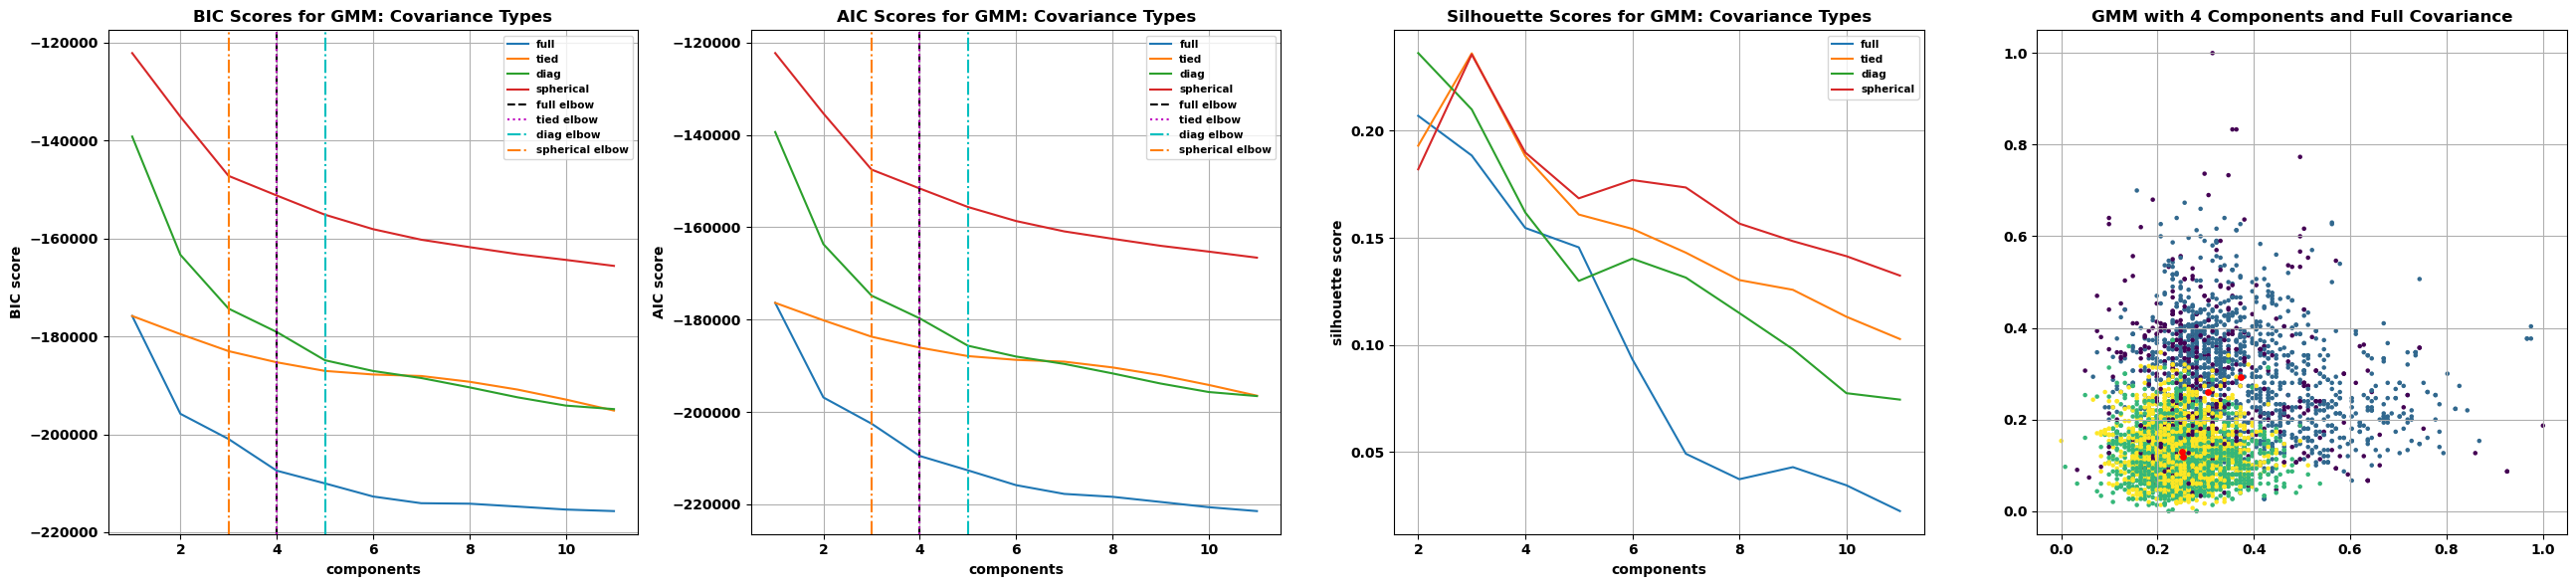

In [18]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(26, 6))
rcParams['font.weight'] = 'bold'

n_components = np.arange(1, 12)
ax1.plot(n_components, bic_full_models, label='full')
ax1.plot(n_components, bic_tied_models, label='tied')
ax1.plot(n_components, bic_diag_models, label='diag')
ax1.plot(n_components, bic_spherical_models, label='spherical')
ax1.axvline(x = bic_full_kn.knee, color='k', label = 'full elbow', linestyle='--')
ax1.axvline(x = bic_tied_kn.knee, color='m', label = 'tied elbow', linestyle=':')
ax1.axvline(x = bic_diag_kn.knee, color='c', label = 'diag elbow', linestyle='-.')
ax1.axvline(x = bic_spherical_kn.knee, color='tab:orange', label = 'spherical elbow', linestyle='-.')
ax1.set_xlabel('components', weight='bold')
ax1.set_ylabel('BIC score', weight='bold')
ax1.legend(loc='best', prop = { "size": 7.5, 'weight':'bold'})
ax1.set_title('BIC Scores for GMM: Covariance Types', weight='bold')
ax1.grid(True)

ax2.plot(n_components, aic_full_models, label='full')
ax2.plot(n_components, aic_tied_models, label='tied')
ax2.plot(n_components, aic_diag_models, label='diag')
ax2.plot(n_components, aic_spherical_models, label='spherical')
ax2.axvline(x = aic_full_kn.knee, color='k', label = 'full elbow', linestyle='--')
ax2.axvline(x = aic_tied_kn.knee, color='m', label = 'tied elbow', linestyle=':')
ax2.axvline(x = aic_diag_kn.knee, color='c', label = 'diag elbow', linestyle='-.')
ax2.axvline(x = aic_spherical_kn.knee, color='tab:orange', label = 'spherical elbow', linestyle='-.')
ax2.set_xlabel('components', weight='bold')
ax2.set_ylabel('AIC score', weight='bold')
ax2.legend(loc='best', prop = { "size": 7.5, 'weight':'bold'})
ax2.set_title('AIC Scores for GMM: Covariance Types', weight='bold')
ax2.grid(True)

n_components = np.arange(2, 12)
ax3.plot(n_components, full_S, label='full')
ax3.plot(n_components, tied_S, label='tied')
ax3.plot(n_components, diag_S, label='diag')
ax3.plot(n_components, sphere_S, label='spherical')
ax3.set_xlabel('components', weight='bold')
ax3.set_ylabel('silhouette score', weight='bold')
ax3.legend(loc='best', prop = { "size": 7.5, 'weight':'bold'})
ax3.set_title('Silhouette Scores for GMM: Covariance Types', weight='bold')
ax3.grid(True)


# ys = []
# cs = []
# for seed in seeds:
gmm = GaussianMixture(4, random_state=seed).fit(wq_scaled)
y_kmeans = gmm.predict(wq_scaled)
# ys.append(y_kmeans)
centers = gmm.means_
# cs.append(centers)
    
# y_kmeans = np.mean(ys, axis=0)
# print(set(y_kmeans))
# centers = np.mean(cs, axis=0)
ax4.scatter(wq_scaled[:, 0], wq_scaled[:, 1], c=y_kmeans, cmap='viridis', s=5)
ax4.scatter(centers[:, 0], centers[:, 1], c='red', s=15)
ax4.set_title('GMM with 4 Components and Full Covariance', weight='bold')
ax4.grid(True)

plt.tight_layout()
plt.savefig(f'plots/gmm_combined/gmm_wq_combined.png', dpi=1200)
plt.show()

#### Analysis

In [19]:
quality = list(wq_y['quality'])
        
        
ri = metrics.rand_score(quality, y_kmeans)
print('Rand Index: ', ri)        
ari = metrics.adjusted_rand_score(quality, y_kmeans)
print('Adjusted Rand Index: ', ari)
ami = metrics.adjusted_mutual_info_score(quality, y_kmeans) 
print('Adjusted Mutual Info Score: ', ami)
nmi = metrics.normalized_mutual_info_score(quality, y_kmeans)  
print('Normalized Mutual Info Score: ', nmi)
homo = metrics.homogeneity_score(quality, y_kmeans)
print('Homogeneity Score: ', homo)
cs = metrics.completeness_score(quality, y_kmeans)
print('Completeness Score: ', cs)
v = metrics.v_measure_score(quality, y_kmeans)
print('V Measure Score: ', v)

Rand Index:  0.5845157029655976
Adjusted Rand Index:  0.03915058645054776
Adjusted Mutual Info Score:  0.048237382093804924
Normalized Mutual Info Score:  0.04931425059164579
Homogeneity Score:  0.04921357138712246
Completeness Score:  0.04941534257178763
V Measure Score:  0.0493142505916458


In [20]:
print(quality)
print(y_kmeans)

[5, 5, 5, 6, 5, 5, 5, 7, 7, 5, 5, 5, 5, 5, 5, 5, 7, 5, 4, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6, 5, 6, 6, 7, 4, 5, 5, 4, 6, 5, 5, 4, 5, 5, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 7, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 4, 5, 5, 5, 6, 5, 4, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 4, 6, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 6, 6, 4, 5, 5, 5, 5, 5, 5, 5, 6, 5, 4, 6, 5, 5, 5, 5, 4, 6, 5, 4, 6, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 7, 4, 7, 5, 5, 5, 6, 7, 7, 5, 5, 7, 6, 6, 6, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 6, 4, 6, 6, 5, 6, 5, 7, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 6, 6, 7, 7, 6, 5, 5, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 7, 5, 4, 5, 5, 5, 7, 4, 8, 6, 6, 6, 6, 5, 5, 5, 6, 6, 6, 8, 7, 6, 7, 5, 7, 5, 5, 6, 6, 7, 5, 7, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5, 6, 7, 6, 7, 5, 5, 6, 6, 6, 7, 5, 6, 5, 6, 6, 6, 

### Breast Cancer

In [21]:
# BIC and AIC
bic_full = []
bic_tied = []
bic_diag = []
bic_sphere = []

aic_full = []
aic_tied = []
aic_diag = []
aic_sphere = []

for seed in seeds:
    n_components = np.arange(1, 31)
    bic_full_models = [GaussianMixture(n, covariance_type='full', random_state=seed).fit(bc_scaled)
              for n in n_components]
    bic_tied_models = [GaussianMixture(n, covariance_type='tied', random_state=seed).fit(bc_scaled)
              for n in n_components]
    bic_diag_models = [GaussianMixture(n, covariance_type='diag', random_state=seed).fit(bc_scaled)
              for n in n_components]
    bic_spherical_models = [GaussianMixture(n, covariance_type='spherical', random_state=seed).fit(bc_scaled)
              for n in n_components]
    
    b1 = [m.bic(bc_scaled) for m in bic_full_models]
    b2 = [m.bic(bc_scaled) for m in bic_tied_models]
    b3 = [m.bic(bc_scaled) for m in bic_diag_models]
    b4 = [m.bic(bc_scaled) for m in bic_spherical_models]
    bic_full.append(b1)
    bic_tied.append(b2)
    bic_diag.append(b3)
    bic_sphere.append(b4)


    aic_full_models = [GaussianMixture(n, covariance_type='full', random_state=seed).fit(bc_scaled)
              for n in n_components]
    aic_tied_models = [GaussianMixture(n, covariance_type='tied', random_state=seed).fit(bc_scaled)
              for n in n_components]
    aic_diag_models = [GaussianMixture(n, covariance_type='diag', random_state=seed).fit(bc_scaled)
              for n in n_components]
    aic_spherical_models = [GaussianMixture(n, covariance_type='spherical', random_state=seed).fit(bc_scaled)
              for n in n_components]
    
    a1 = [m.aic(bc_scaled) for m in aic_full_models]
    a2 = [m.aic(bc_scaled) for m in aic_tied_models]
    a3 = [m.aic(bc_scaled) for m in aic_diag_models]
    a4 = [m.aic(bc_scaled) for m in aic_spherical_models]
    aic_full.append(a1)
    aic_tied.append(a2)
    aic_diag.append(a3)
    aic_sphere.append(a4)

bic_full_models = np.mean(bic_full, axis=0)
bic_tied_models = np.mean(bic_tied, axis=0)
bic_diag_models = np.mean(bic_diag, axis=0)
bic_spherical_models = np.mean(bic_sphere, axis=0)

aic_full_models = np.mean(aic_full, axis=0)
aic_tied_models = np.mean(aic_tied, axis=0)
aic_diag_models = np.mean(aic_diag, axis=0)
aic_spherical_models = np.mean(aic_sphere, axis=0)
    
bic_full_kn = KneeLocator(n_components, bic_full_models, curve='convex', direction='decreasing')
bic_tied_kn = KneeLocator(n_components, bic_tied_models, curve='convex', direction='decreasing')
bic_diag_kn = KneeLocator(n_components, bic_diag_models, curve='convex', direction='decreasing')
bic_spherical_kn = KneeLocator(n_components, bic_spherical_models, curve='convex', direction='decreasing')    
    
aic_full_kn = KneeLocator(n_components, aic_full_models, curve='convex', direction='decreasing')
aic_tied_kn = KneeLocator(n_components, aic_tied_models, curve='convex', direction='decreasing')
aic_diag_kn = KneeLocator(n_components, aic_diag_models, curve='convex', direction='decreasing')
aic_spherical_kn = KneeLocator(n_components, aic_spherical_models, curve='convex', direction='decreasing')

In [22]:
# Silhouette

holder1 = []
holder2 = []
holder3 = []
holder4 = []
n_components = np.arange(2, 31)

for seed in seeds:
    full_S = []
    tied_S = []
    diag_S = []
    sphere_S = []
    for n in n_components:
        full_model = GaussianMixture(n, covariance_type='full', random_state=seed)
        tied_model = GaussianMixture(n, covariance_type='tied', random_state=seed)
        diag_model = GaussianMixture(n, covariance_type='diag', random_state=seed)
        sphere_model = GaussianMixture(n, covariance_type='spherical', random_state=seed)

        full_labels = full_model.fit_predict(bc_scaled)
        tied_labels = tied_model.fit_predict(bc_scaled)
        diag_labels = diag_model.fit_predict(bc_scaled)
        sphere_labels = sphere_model.fit_predict(bc_scaled)

        full_S.append(metrics.silhouette_score(bc_scaled, full_labels))
        tied_S.append(metrics.silhouette_score(bc_scaled, tied_labels))
        diag_S.append(metrics.silhouette_score(bc_scaled, diag_labels))
        sphere_S.append(metrics.silhouette_score(bc_scaled, sphere_labels))
    holder1.append(full_S)
    holder2.append(tied_S)
    holder3.append(diag_S)
    holder4.append(sphere_S)
full_S = np.mean(holder1, axis=0)
tied_S = np.mean(holder2, axis=0)
diag_S = np.mean(holder3, axis=0)
sphere_S = np.mean(holder4, axis=0)

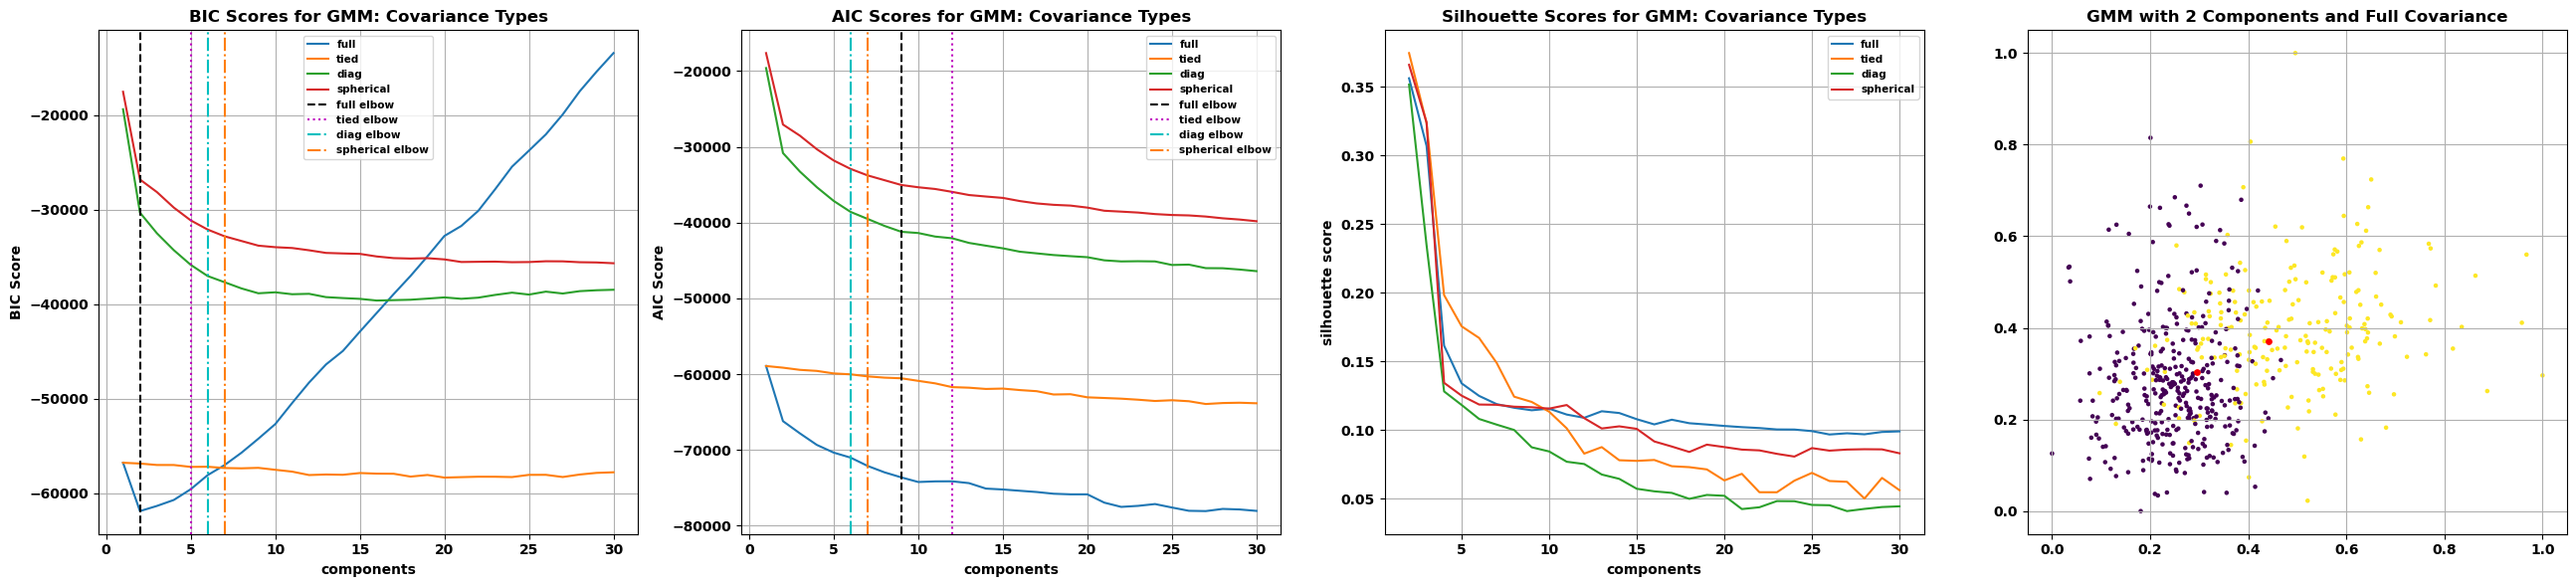

In [23]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(26, 6))
rcParams['font.weight'] = 'bold'

n_components = np.arange(1, 31)
ax1.plot(n_components, bic_full_models, label='full')
ax1.plot(n_components, bic_tied_models, label='tied')
ax1.plot(n_components, bic_diag_models, label='diag')
ax1.plot(n_components, bic_spherical_models, label='spherical')
ax1.axvline(x = bic_full_kn.knee, color='k', label = 'full elbow', linestyle='--')
ax1.axvline(x = bic_tied_kn.knee, color='m', label = 'tied elbow', linestyle=':')
ax1.axvline(x = bic_diag_kn.knee, color='c', label = 'diag elbow', linestyle='-.')
ax1.axvline(x = bic_spherical_kn.knee, color='tab:orange', label = 'spherical elbow', linestyle='-.')
ax1.set_xlabel('components', weight='bold')
ax1.set_ylabel('BIC Score', weight='bold')
ax1.legend(loc='best', prop = { "size": 7.5, 'weight':'bold'})
ax1.set_title('BIC Scores for GMM: Covariance Types', weight='bold')
ax1.grid(True)

ax2.plot(n_components, aic_full_models, label='full')
ax2.plot(n_components, aic_tied_models, label='tied')
ax2.plot(n_components, aic_diag_models, label='diag')
ax2.plot(n_components, aic_spherical_models, label='spherical')
ax2.axvline(x = aic_full_kn.knee, color='k', label = 'full elbow', linestyle='--')
ax2.axvline(x = aic_tied_kn.knee, color='m', label = 'tied elbow', linestyle=':')
ax2.axvline(x = aic_diag_kn.knee, color='c', label = 'diag elbow', linestyle='-.')
ax2.axvline(x = aic_spherical_kn.knee, color='tab:orange', label = 'spherical elbow', linestyle='-.')
ax2.set_xlabel('components', weight='bold')
ax2.set_ylabel('AIC Score', weight='bold')
ax2.legend(loc='best', prop = { "size": 7.5, 'weight':'bold'})
ax2.set_title('AIC Scores for GMM: Covariance Types', weight='bold')
ax2.grid(True)

n_components = np.arange(2, 31)
ax3.plot(n_components, full_S, label='full')
ax3.plot(n_components, tied_S, label='tied')
ax3.plot(n_components, diag_S, label='diag')
ax3.plot(n_components, sphere_S, label='spherical')
ax3.set_xlabel('components', weight='bold')
ax3.set_ylabel('silhouette score', weight='bold')
ax3.legend(loc='best', prop = { "size": 7.5, 'weight':'bold'})
ax3.set_title('Silhouette Scores for GMM: Covariance Types', weight='bold')
ax3.grid(True)

ys = []
cs = []
for seed in seeds:
    gmm = GaussianMixture(2, random_state=seed).fit(bc_scaled)
    y_kmeans = gmm.predict(bc_scaled)
    ys.append(y_kmeans)
    centers = gmm.means_
    cs.append(centers)
    
y_kmeans = np.mean(ys, axis=0)
centers = np.mean(cs, axis=0)
ax4.scatter(bc_scaled[:, 0], bc_scaled[:, 1], c=y_kmeans, cmap='viridis', s=5)
ax4.scatter(centers[:, 0], centers[:, 1], c='red', s=15)
ax4.set_title('GMM with 2 Components and Full Covariance', weight='bold')
ax4.grid(True)

plt.tight_layout()
plt.savefig(f'plots/gmm_combined/gmm_bc_combined.png', dpi=1200)

In [24]:
diagnosis = list(bc_y['Diagnosis'])
for i in range(len(diagnosis)):
    if diagnosis[i] == 'M':
        diagnosis[i] = 1
    else:
        diagnosis[i] = 0
        
        
ri = metrics.rand_score(diagnosis, y_kmeans)
print('Rand Index: ', ri)        
ari = metrics.adjusted_rand_score(diagnosis, y_kmeans)
print('Adjusted Rand Index: ', ari)
ami = metrics.adjusted_mutual_info_score(diagnosis, y_kmeans) 
print('Adjusted Mutual Info Score: ', ami)
nmi = metrics.normalized_mutual_info_score(diagnosis, y_kmeans)  
print('Normalized Mutual Info Score: ', nmi)
homo = metrics.homogeneity_score(diagnosis, y_kmeans)
print('Homogeneity Score: ', homo)
cs = metrics.completeness_score(diagnosis, y_kmeans)
print('Completeness Score: ', cs)
v = metrics.v_measure_score(diagnosis, y_kmeans)
print('V Measure Score: ', v)

Rand Index:  0.8905418450951756
Adjusted Rand Index:  0.7802280559794731
Adjusted Mutual Info Score:  0.6675929609101091
Normalized Mutual Info Score:  0.6680364111188509
Homogeneity Score:  0.6684963776600907
Completeness Score:  0.6675770771128159
V Measure Score:  0.6680364111188509


/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete valu

In [25]:
print(diagnosis)
print(y_kmeans)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 